In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [23]:
raw_matchups = pd.read_csv("Tournament Matchups.csv")

# 2024 bracket isn't even made but they are still in the data set so just remove them and drop columns we won't be using
## year/team pair will serve as index
raw_matchups = raw_matchups[raw_matchups["YEAR"] != 2024].drop(columns=["BY YEAR NO", "BY ROUND NO", "TEAM NO"])

raw_matchups.head()

,YEAR,TEAM,SEED,ROUND,CURRENT ROUND,SCORE
146,2023,Alabama,1,16,64,96.0
147,2023,Texas A&M Corpus Chris,16,64,64,75.0
148,2023,Maryland,8,32,64,67.0
149,2023,West Virginia,9,64,64,65.0
150,2023,San Diego St.,5,2,64,63.0


In [24]:
raw_matchups[raw_matchups["YEAR"] == 2021].TEAM.unique().size

63

2021 is missing a team, probably something COVID-related, so I will just drop that year from all our data.

In [25]:
raw_matchups = raw_matchups[raw_matchups['YEAR'] != 2021]

Merge with the team stats to have all the information in one place:

In [26]:
stats = pd.read_csv("raw_stats.csv").drop(columns=["Unnamed: 0"])
raw_matchup_stats = pd.merge(raw_matchups, stats, on=["YEAR", "TEAM"], how="left").drop(columns=["SEED_y", "ROUND_y"])
raw_matchup_stats.rename(columns={"SEED_x":"SEED", "ROUND_x":"ROUND"}, inplace=True)

In [27]:
raw_matchup_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1764 entries, 0 to 1763
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YEAR           1764 non-null   int64  
 1   TEAM           1764 non-null   object 
 2   SEED           1764 non-null   int64  
 3   ROUND          1764 non-null   int64  
 4   CURRENT ROUND  1764 non-null   int64  
 5   SCORE          1764 non-null   float64
 6   WAB            1755 non-null   float64
 7   BADJ EM        1755 non-null   float64
 8   BARTHAG        1755 non-null   float64
 9   TALENT         1755 non-null   float64
 10  ELITE SOS      1755 non-null   float64
 11  WIN%           1755 non-null   float64
 12  PPPO           1755 non-null   float64
 13  K OFF          1755 non-null   float64
dtypes: float64(9), int64(4), object(1)
memory usage: 206.7+ KB


I am noticing a discrepancy in the merges so I will have to investigate why that is happening. We need every game for every round to make a useful predictor.

Check which teams are missing from each:

In [28]:
unique_teams_matchups = set(raw_matchups["TEAM"].unique())
unique_teams_stats = set(stats["TEAM"].unique())

# Teams present in raw_matchups but not in stats_data
teams_only_in_matchups = unique_teams_matchups - unique_teams_stats

# Teams present in stats_data but not in raw_matchups
teams_only_in_stats = unique_teams_stats - unique_teams_matchups

print("Teams only in matchups:", teams_only_in_matchups)
print("Teams only in stats:", teams_only_in_stats)

Teams only in matchups: {'Texas ', 'Virginia '}
Teams only in stats: {'Prairie View A&M', 'New Orleans', 'Rutgers', 'North Florida', 'Alabama St.', 'Bryant', 'Coppin St.', 'Southeast Missouri St.', 'Lamar'}


At least part of the problem seems to be trailing white space, so I will remove that.

In [29]:
# Assuming raw_matchups and stats_data are your DataFrames containing the matchups and stats data respectively
raw_matchups["TEAM"] = raw_matchups["TEAM"].str.strip()
stats["TEAM"] = stats["TEAM"].str.strip()

unique_teams_matchups = set(raw_matchups["TEAM"].unique())
unique_teams_stats = set(stats["TEAM"].unique())

# Teams present in raw_matchups but not in stats_data
teams_only_in_matchups = unique_teams_matchups - unique_teams_stats

# Teams present in stats_data but not in raw_matchups
teams_only_in_stats = unique_teams_stats - unique_teams_matchups

print("Teams only in matchups:", teams_only_in_matchups)
print("Teams only in stats:", teams_only_in_stats)

Teams only in matchups: set()
Teams only in stats: {'Prairie View A&M', 'New Orleans', 'Rutgers', 'North Florida', 'Alabama St.', 'Bryant', 'Coppin St.', 'Southeast Missouri St.', 'Lamar'}


That solved the problem for some of them. I think that maybe these teams in stats were in the play-in games (round of 68) and the matchups data set may only start at round of 64. I will check for that.

In [30]:
stats[stats['TEAM'].isin(teams_only_in_stats)]

,YEAR,TEAM,SEED,ROUND,WAB,BADJ EM,BARTHAG,TALENT,ELITE SOS,WIN%,PPPO,K OFF
51,2023,Southeast Missouri St.,16,68,-11.6,-8.2,0.285,2.128,8.545,51.515152,1.028,102.6640
75,2022,Bryant,16,68,-4.8,-1.5,0.458,3.998,9.639,70.000000,1.051,105.2750
113,2022,Rutgers,11,68,-0.7,9.0,0.738,51.706,28.945,58.064520,1.025,102.6970
182,2019,Prairie View A&M,16,68,-6.9,-4.1,0.388,1.736,9.729,63.636360,1.031,103.1200
304,2017,New Orleans,16,68,-6.3,-1.9,0.446,0.455,11.906,60.714290,1.015,101.9040
445,2015,North Florida,16,68,-5.1,0.4,0.511,11.873,14.080,64.516130,1.094,109.6330
636,2012,Lamar,16,68,-4.3,4.3,0.619,0.870,15.047,65.625000,1.055,104.7930
681,2011,Alabama St.,16,68,-13.0,-15.5,0.139,0.200,8.673,46.875000,0.926,92.1392
814,2009,Alabama St.,16,68,-5.1,-3.0,0.416,0.201,10.210,68.965520,1.039,105.0130
890,2008,Coppin St.,16,68,-13.0,-15.4,0.140,4.120,16.141,41.176470,0.907,90.6896


As expected, all of these teams lost in the round of 68. For the sake of simplicity and working with the data we have, I will make this predictor only on the actual tournament games, excluding play-ins. 

Now, remerge the data with the corrections (removed white spaces and a left merge to drop R68 teams from stats):

In [31]:
raw_matchup_stats = pd.merge(raw_matchups, stats, on=["YEAR", "TEAM"], how="left").drop(columns=["SEED_y", "ROUND_y"])
raw_matchup_stats.rename(columns={"SEED_x":"SEED", "ROUND_x":"ROUND"}, inplace=True)

In [32]:
raw_matchup_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1764 entries, 0 to 1763
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YEAR           1764 non-null   int64  
 1   TEAM           1764 non-null   object 
 2   SEED           1764 non-null   int64  
 3   ROUND          1764 non-null   int64  
 4   CURRENT ROUND  1764 non-null   int64  
 5   SCORE          1764 non-null   float64
 6   WAB            1764 non-null   float64
 7   BADJ EM        1764 non-null   float64
 8   BARTHAG        1764 non-null   float64
 9   TALENT         1764 non-null   float64
 10  ELITE SOS      1764 non-null   float64
 11  WIN%           1764 non-null   float64
 12  PPPO           1764 non-null   float64
 13  K OFF          1764 non-null   float64
dtypes: float64(9), int64(4), object(1)
memory usage: 206.7+ KB


Looks good.

#### Data description from Kaggle: 

The matchups and final score of each team in the tournament. Each matchup is every two rows. For example, the first matchup in 2023 is Alabama vs. Texas A&M Corpus Chris with a final score of 96 - 75 with Alabama winning. The next matchup would be Maryland vs. West Virginia with a final score of 67 to 65 with Maryland winning.

Knowing how its made, I can put the matchups on 1 row instead of 2.

In [33]:
matchups = pd.DataFrame(columns=['year', 'team_1', 'seed_1', 'round_1', 'current_round', 'score_1',
                                 'team_2', 'seed_2', 'round_2', 'score_2'])

# iterate through data frame and jump 2 each iteration
for i in range(0, len(raw_matchup_stats), 2):
    team1_info = raw_matchup_stats.iloc[i]
    team2_info = raw_matchup_stats.iloc[i+1]
    
    matchup_info = {
        'year': team1_info['YEAR'],
        'team_1': team1_info['TEAM'],
        'seed_1': team1_info['SEED'],
        'round_1': team1_info['ROUND'],
        'score_1' : team1_info['SCORE'],
        'score_2' : team2_info['SCORE'],
        'current_round': team1_info['CURRENT ROUND'],
        'team_2': team2_info['TEAM'],
        'seed_2': team2_info['SEED'],
        'round_2': team2_info['ROUND'],
        'badj_em_1': team1_info['BADJ EM'],
        'wab_1': team1_info['WAB'],
        'barthag_1': team1_info['BARTHAG'],
        'talent_1': team1_info['TALENT'],
        'elite_sos_1': team1_info['ELITE SOS'],
        'win_percent_1': team1_info['WIN%'],
        'pppo_1': team1_info['PPPO'],
        'k_off_1': team1_info['K OFF'],
        'badj_em_2': team2_info['BADJ EM'],
        'wab_2': team2_info['WAB'],
        'barthag_2': team2_info['BARTHAG'],
        'talent_2': team2_info['TALENT'],
        'elite_sos_2': team2_info['ELITE SOS'],
        'win_percent_2': team2_info['WIN%'],
        'pppo_2': team2_info['PPPO'],
        'k_off_2': team2_info['K OFF']
    }
    
    matchups = matchups.append(matchup_info, ignore_index=True)

In [34]:
# get the winner of each game (1 = team 1 wins, 0 = team 2 wins)
matchups["winner"] = 1 * (matchups["score_1"] > matchups["score_2"])

# don't need score anymore because that is not something we are predicting... only winner
matchups.drop(columns=["score_1", "score_2"], inplace=True)

In [35]:
matchups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           882 non-null    object 
 1   team_1         882 non-null    object 
 2   seed_1         882 non-null    object 
 3   round_1        882 non-null    object 
 4   current_round  882 non-null    object 
 5   team_2         882 non-null    object 
 6   seed_2         882 non-null    object 
 7   round_2        882 non-null    object 
 8   badj_em_1      882 non-null    float64
 9   badj_em_2      882 non-null    float64
 10  barthag_1      882 non-null    float64
 11  barthag_2      882 non-null    float64
 12  elite_sos_1    882 non-null    float64
 13  elite_sos_2    882 non-null    float64
 14  k_off_1        882 non-null    float64
 15  k_off_2        882 non-null    float64
 16  pppo_1         882 non-null    float64
 17  pppo_2         882 non-null    float64
 18  talent_1  

In [36]:
matchups.head()

,year,team_1,seed_1,round_1,current_round,team_2,seed_2,round_2,badj_em_1,badj_em_2,...,k_off_2,pppo_1,pppo_2,talent_1,talent_2,wab_1,wab_2,win_percent_1,win_percent_2,winner
0,2023,Alabama,1,16,64,Texas A&M Corpus Chris,16,64,27.1,-1.8,...,109.864,1.106,1.098,66.119,3.833,10.2,-6.0,85.294118,65.517241,1
1,2023,Maryland,8,32,64,West Virginia,9,64,16.5,19.7,...,108.969,1.086,1.088,44.421,40.731,1.0,1.5,63.636364,57.575758,1
2,2023,San Diego St.,5,2,64,College of Charleston,12,64,21.2,11.5,...,112.460,1.064,1.126,37.236,0.200,5.8,1.7,81.250000,90.909091,1
3,2023,Virginia,4,64,64,Furman,13,32,16.9,7.8,...,115.465,1.083,1.155,54.569,4.159,4.1,-2.0,78.125000,77.419355,0
4,2023,Creighton,6,8,64,North Carolina St.,11,64,21.0,15.2,...,111.298,1.095,1.115,67.359,54.561,1.9,1.1,63.636364,69.696970,1


Now the two teams are in one dataset with all of their stats. This is so many variables so I am going to get the difference between each corresponding variable. For example, (k off diff = k_off1 - koff2)

I will use only the differenced variables in the model, but I still have to keep the other the individual team stats for when I simulate the bracket and there are new matchups.

In [37]:
stat_variables = ['badj_em', 'wab', 'barthag', 'talent', 'elite_sos', 'win_percent', 'pppo', 'k_off']
for variable in stat_variables:
    matchups[f'{variable}_diff'] = matchups[f'{variable}_1'] - matchups[f'{variable}_2']

In [38]:
matchups.head()

,year,team_1,seed_1,round_1,current_round,team_2,seed_2,round_2,badj_em_1,badj_em_2,...,win_percent_2,winner,badj_em_diff,wab_diff,barthag_diff,talent_diff,elite_sos_diff,win_percent_diff,pppo_diff,k_off_diff
0,2023,Alabama,1,16,64,Texas A&M Corpus Chris,16,64,27.1,-1.8,...,65.517241,1,28.9,16.2,0.505,62.286,24.154,19.776876,0.008,0.998
1,2023,Maryland,8,32,64,West Virginia,9,64,16.5,19.7,...,57.575758,1,-3.2,-0.5,-0.032,3.690,-6.315,6.060606,-0.002,0.056
2,2023,San Diego St.,5,2,64,College of Charleston,12,64,21.2,11.5,...,90.909091,1,9.7,4.1,0.137,37.036,16.740,-9.659091,-0.062,-5.790
3,2023,Virginia,4,64,64,Furman,13,32,16.9,7.8,...,77.419355,0,9.1,6.1,0.174,50.410,14.426,0.705645,-0.072,-7.131
4,2023,Creighton,6,8,64,North Carolina St.,11,64,21.0,15.2,...,69.696970,1,5.8,0.8,0.073,12.798,8.184,-6.060606,-0.020,-1.706


#### Look at the distribution of winners:

In [39]:
matchups["winner"].value_counts()

1    544
0    338
Name: winner, dtype: int64

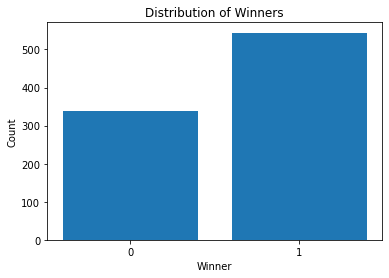

In [40]:
winner_counts = matchups["winner"].value_counts()
plt.bar(winner_counts.index, winner_counts.values)
plt.xlabel("Winner")
plt.ylabel("Count")
plt.title("Distribution of Winners")
plt.xticks(winner_counts.index, [1, 0])
plt.show()

The distribution seems to be fairly balanced.

#### Look at the distributions of each predictor by winner:

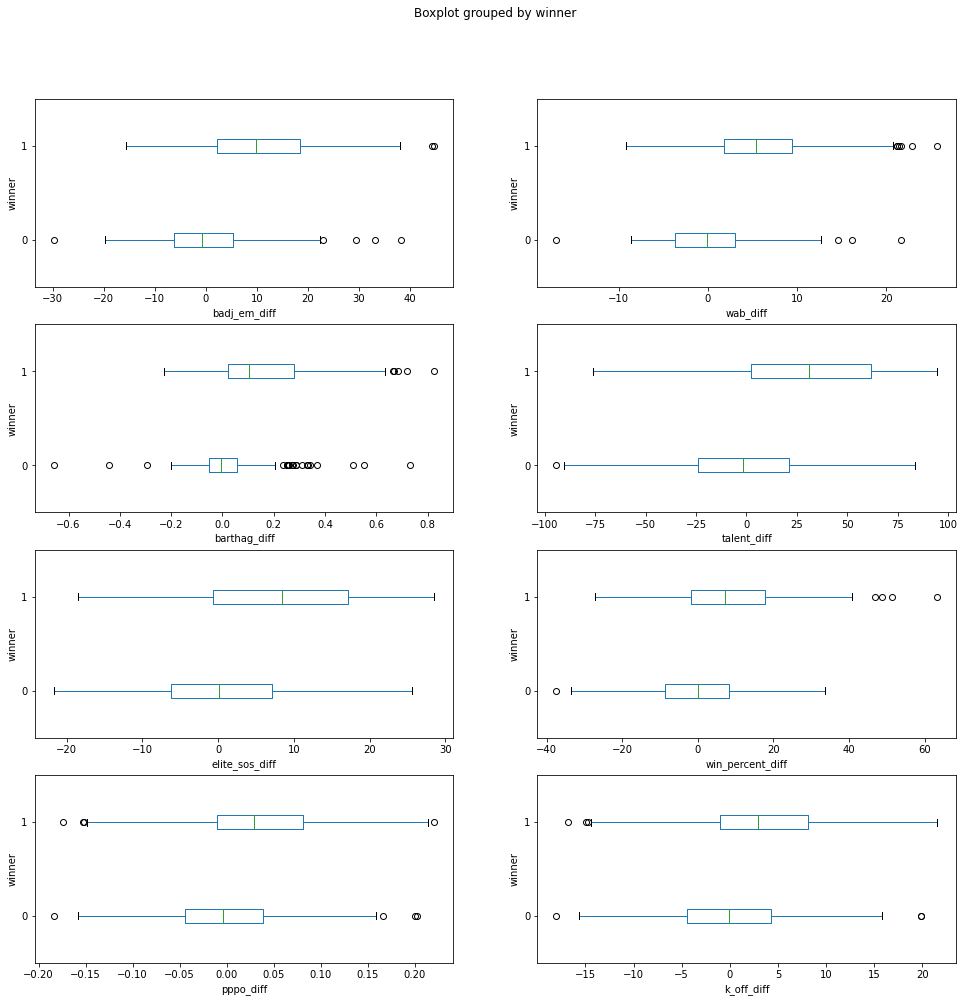

In [41]:
predictors = matchups.columns[25:]
target = "winner"

num_cols = 2
num_rows = len(predictors) // num_cols + (len(predictors) % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))

for i, predictor in enumerate(predictors):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    matchups.boxplot(column=predictor, by=target, grid=False, vert=False, ax=ax)
    ax.set_title('')
    ax.set_ylabel(target)
    ax.set_xlabel(predictor)

*Note:* Team 2 comes from the bottom of the bracket, which means they are generally a lower seed unless something happened in the round before (an upset from them or from Team 1) that changed this. Basically, in the first round, all Team 2's are a lower seed, but it could change after that. 

These plots show that, on average, team 2 wins more when the statistic is close to zero (generally representing an equal matchup). There is a wide range and tons of overlap on the boxplots, but March Madness is historically unpredictable, so this makes sense. We are just trying to do better than blind guessing. 

In [42]:
matchups.to_csv("matchups.csv")